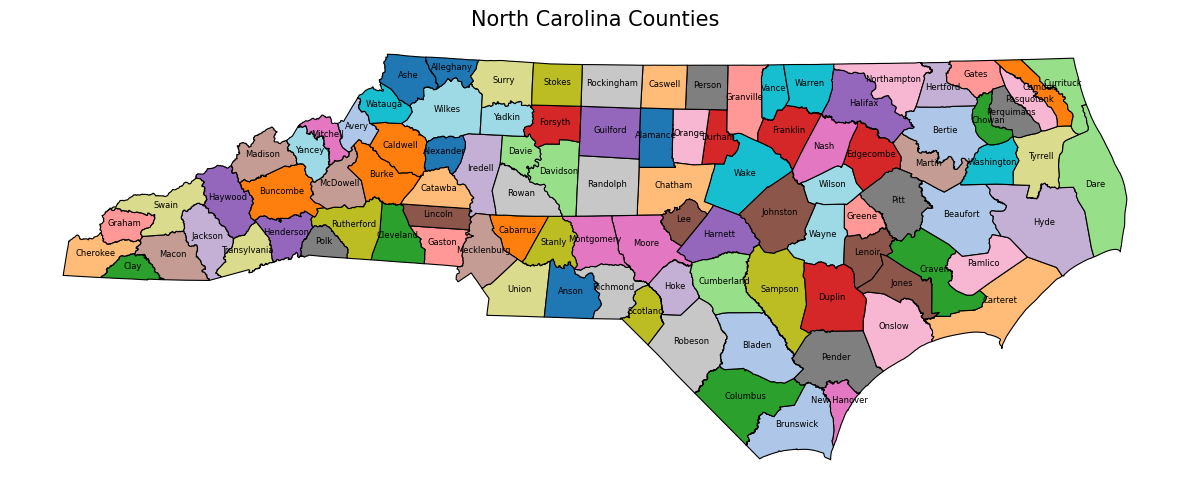

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt

nc_counties = gpd.read_file('Boundaries/NCDOT_County_Boundaries.shp')

nc_counties['centroid'] = nc_counties.geometry.centroid

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nc_counties.plot(
    column='NAME',
    cmap='tab20',
    linewidth=0.8,
    ax=ax,
    edgecolor='black'
)

# Add county names
for _, row in nc_counties.iterrows():
    ax.annotate(
        text=row['NAME'],
        xy=(row['centroid'].x, row['centroid'].y),
        fontsize=6,
        ha='center',
        color='black'
    )

ax.set_title('North Carolina Counties', fontdict={'fontsize': '15', 'fontweight': '3'})

ax.axis('off')

plt.tight_layout()
plt.show()

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = 'Data/data.csv'  # Update with the actual path to your file
raw_data = pd.read_csv(file_path)

# Remove commas from numeric values
raw_data = raw_data.replace(",", "", regex=True)

# Transpose the dataset to make counties rows and dates columns
cleaned_data = raw_data.set_index("Date").T.reset_index()

# Rename the "index" column to "County" for clarity
cleaned_data.rename(columns={"index": "County"}, inplace=True)

# Convert numeric columns to proper numeric types
for col in cleaned_data.columns[1:]:
    cleaned_data[col] = pd.to_numeric(cleaned_data[col], errors='coerce')

cleaned_data.to_csv('Data/transposed_data.csv', index=False)


# Z-score normalization across rows (excluding the "County" column)
scaler = StandardScaler()
normalized_values = scaler.fit_transform(cleaned_data.iloc[:, 1:])

# Create a DataFrame for normalized data
normalized_data = pd.DataFrame(
    normalized_values,
    columns=cleaned_data.columns[1:],
    index=cleaned_data['County']
).reset_index()

normalized_data.to_csv('Data/transposed_normalized_data.csv', index=False)

Select the dataset to use:
1: Data/transposed_data.csv
2: Data/transposed_normalized_data.csv


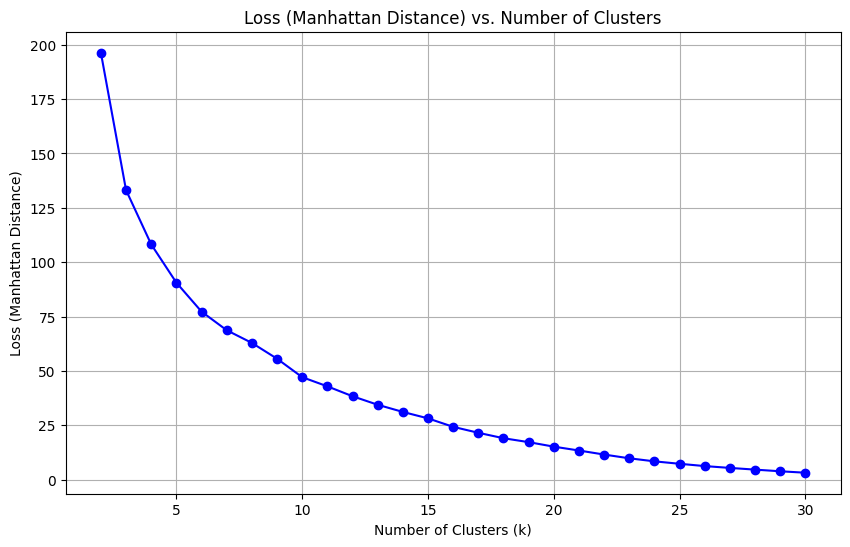

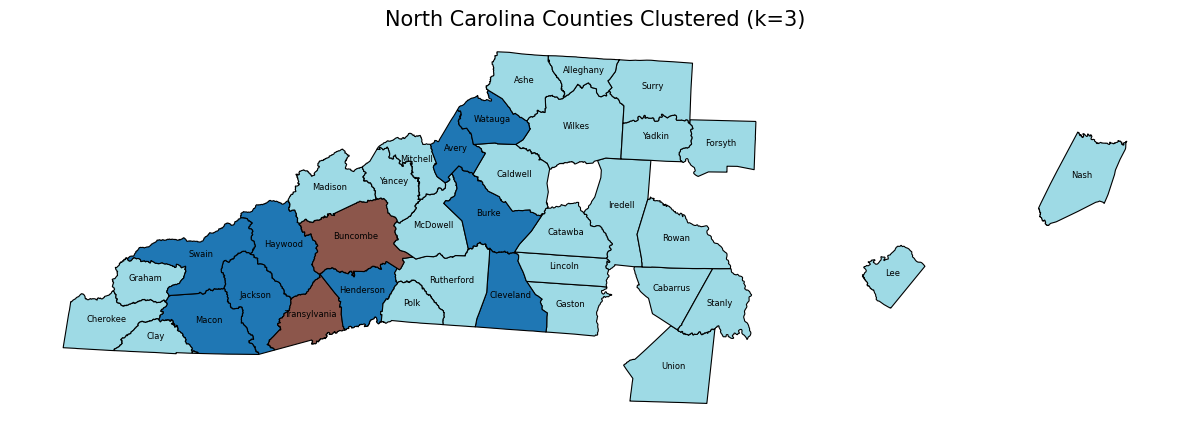

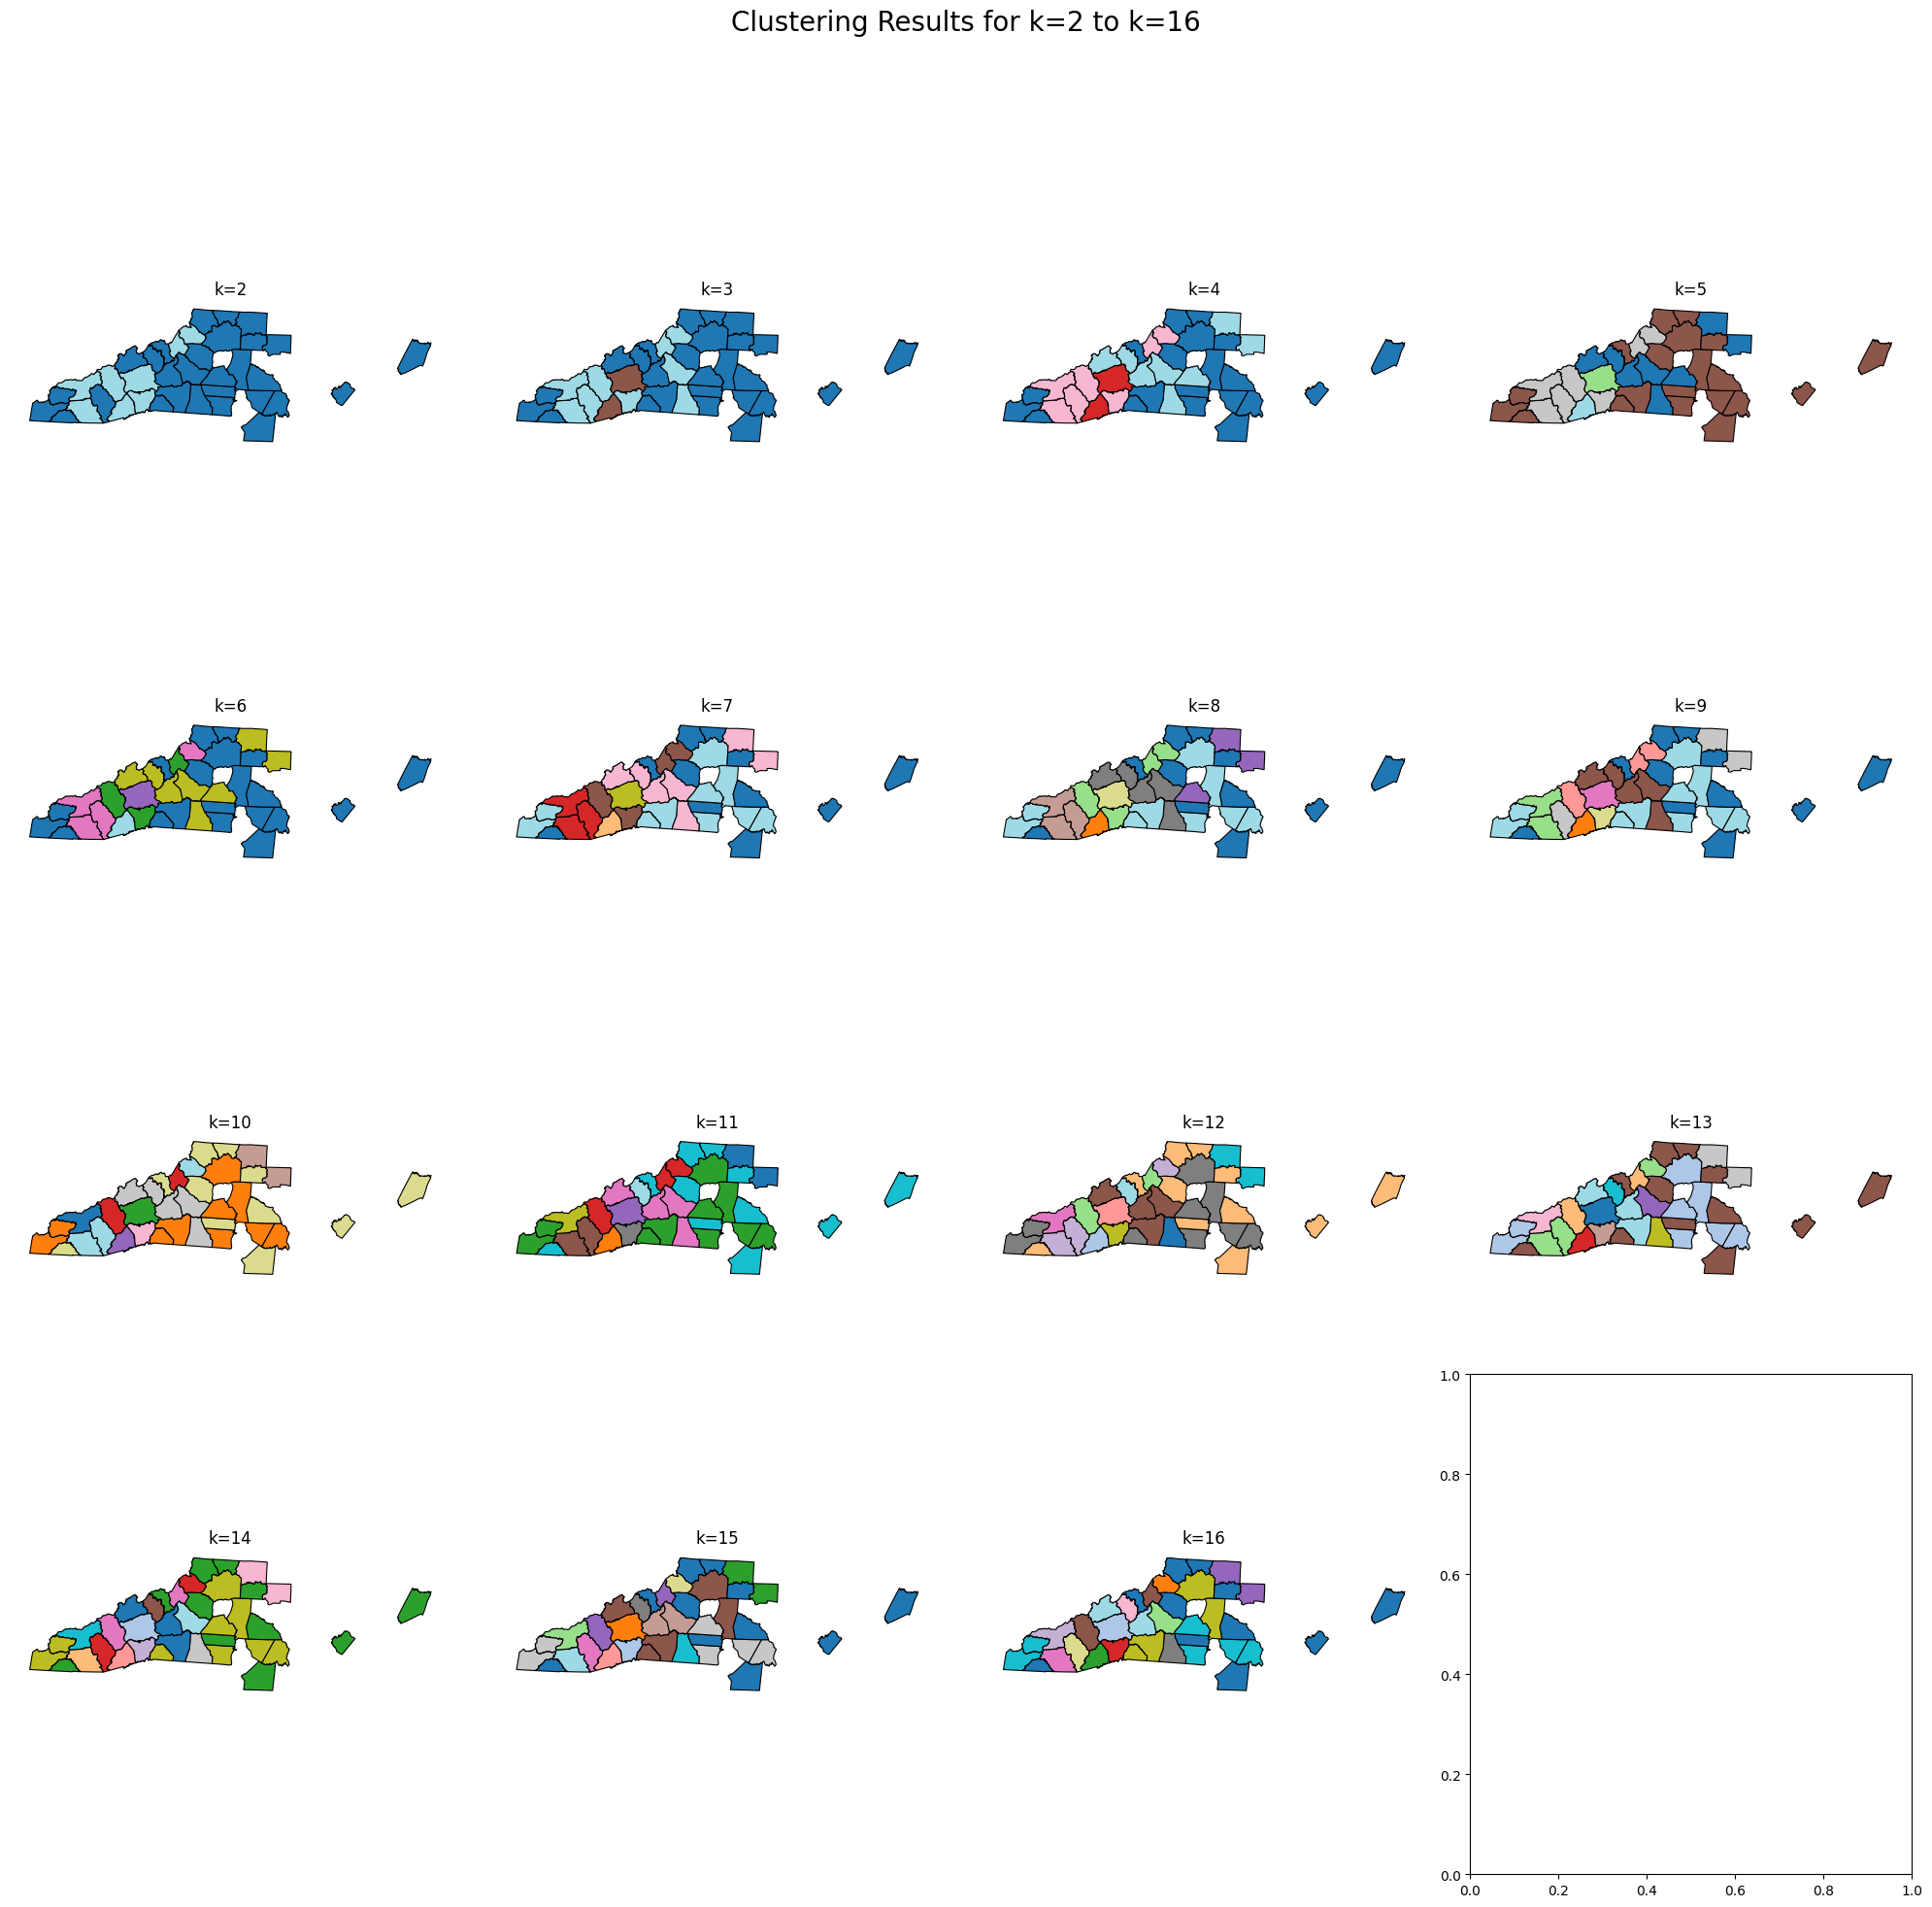

In [27]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import os

# Ask user which dataset to use
def select_dataset():
    print("Select the dataset to use:")
    print("1: Data/transposed_data.csv")
    print("2: Data/transposed_normalized_data.csv")
    choice = input("Enter 1 or 2: ").strip()
    if choice == "1":
        return "Data/transposed_data.csv"
    elif choice == "2":
        return "Data/transposed_normalized_data.csv"
    else:
        print("Invalid choice. Defaulting to Data/transposed_data.csv.")
        return "Data/transposed_data.csv"
    
# Ask user which years to include
def filter_years(data):
    include_2024 = input("Include 2024 data? (yes/no): ").strip().lower() == "yes"
    include_2023 = input("Include 2023 data? (yes/no): ").strip().lower() == "yes"
    include_2022 = input("Include 2022 data? (yes/no): ").strip().lower() == "yes"

    columns_to_keep = ["County"]
    if include_2024:
        columns_to_keep.extend([col for col in data.columns if col.startswith("2024")])
    if include_2023:
        columns_to_keep.extend([col for col in data.columns if col.startswith("2023")])
    if include_2022:
        columns_to_keep.extend([col for col in data.columns if col.startswith("2022")])

    return data[columns_to_keep]

# Load the selected dataset
data_path = select_dataset()
if os.path.exists(data_path):
    normalized_data = pd.read_csv(data_path)
else:
    raise FileNotFoundError(f"The file {data_path} does not exist.")

normalized_data = filter_years(normalized_data)

# Separate County column and normalized values
county_names = normalized_data['County']
normalized_values = normalized_data.drop(columns=['County']).values

# Custom KMeans with Manhattan distance
class KMeansManhattan(KMeans):
    def fit(self, X, y=None):
        self._metric = 'cityblock'
        return super().fit(X, y)

# Calculate loss (inertia) for k = 2 through k = 30, running KMeans 5 times for each k
k_values = range(2, 31)
inertia_values = []
best_kmeans_per_k = {}

for k in k_values:
    best_inertia = float('inf')
    best_kmeans = None
    for _ in range(10):  # Run KMeans 5 times
        kmeans = KMeansManhattan(n_clusters=k, random_state=np.random.randint(0, 1000)).fit(normalized_values)
        inertia = np.sum(np.min(cdist(normalized_values, kmeans.cluster_centers_, metric='cityblock'), axis=1))
        if inertia < best_inertia:
            best_inertia = inertia
            best_kmeans = kmeans
    inertia_values.append(best_inertia)
    best_kmeans_per_k[k] = best_kmeans

# Plot loss (inertia) as a function of the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_values, marker='o', linestyle='-', color='b')
plt.title("Loss (Manhattan Distance) vs. Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Loss (Manhattan Distance)")
plt.grid(True)
plt.show()

# Ask user to pick k
k = int(input("Enter the number of clusters to visualize on the map (k): "))

# Run K-Means for the chosen k 10 times and pick the best
best_inertia = float('inf')
best_kmeans = None
for _ in range(15):
    kmeans = KMeansManhattan(n_clusters=k, random_state=np.random.randint(0, 1000)).fit(normalized_values)
    inertia = np.sum(np.min(cdist(normalized_values, kmeans.cluster_centers_, metric='cityblock'), axis=1))
    if inertia < best_inertia:
        best_inertia = inertia
        best_kmeans = kmeans

# Assign clusters for the best KMeans
normalized_data['Cluster'] = best_kmeans.labels_

# Load geographic data for NC counties
nc_counties = gpd.read_file("Boundaries/NCDOT_County_Boundaries.shp")  # Update with the correct path
nc_counties['NAME'] = nc_counties['NAME'].str.strip()  # Ensure no trailing spaces in county names

# Merge cluster labels with geographic data
merged_data = nc_counties.merge(normalized_data, left_on='NAME', right_on='County')

# Plot the best clustering result for the chosen k
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
merged_data['centroid'] = merged_data.geometry.centroid
merged_data.plot(
    column='Cluster',
    cmap='tab20',
    linewidth=0.8,
    ax=ax,
    edgecolor='black'
)

# Add county names as annotations
for _, row in merged_data.iterrows():
    ax.annotate(
        text=row['NAME'],
        xy=(row['centroid'].x, row['centroid'].y),
        fontsize=6,
        ha='center',
        color='black'
    )

ax.set_title(f"North Carolina Counties Clustered (k={k})", fontdict={'fontsize': '15', 'fontweight': '3'})
ax.axis('off')
plt.tight_layout()
plt.show()

# Subplot visualizations for k = 2 through 16
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle("Clustering Results for k=2 to k=16", fontsize=20)

for i, k in enumerate(range(2, 17)):
    ax = axes[i // 4, i % 4]
    kmeans = best_kmeans_per_k[k]
    normalized_data['Cluster'] = kmeans.labels_
    merged_data = nc_counties.merge(normalized_data, left_on='NAME', right_on='County')
    merged_data['centroid'] = merged_data.geometry.centroid
    merged_data.plot(
        column='Cluster',
        cmap='tab20',
        linewidth=0.8,
        ax=ax,
        edgecolor='black'
    )
    ax.set_title(f"k={k}")
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust title position
plt.show()


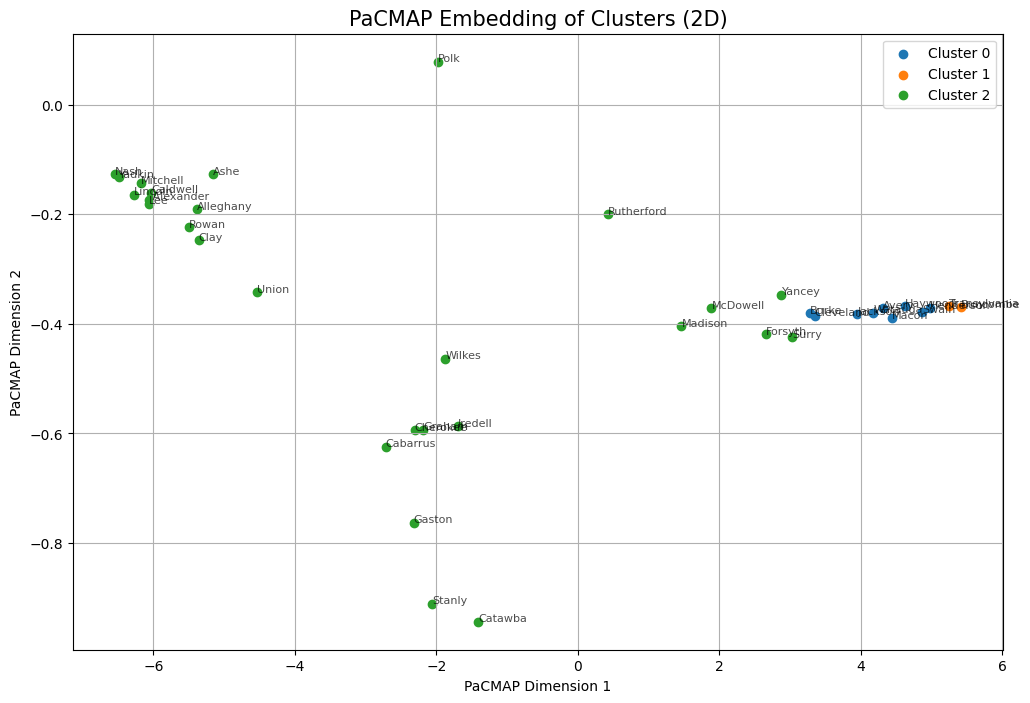

In [31]:

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import pacmap
from sklearn.decomposition import PCA
import plotly.express as px

normalized_data['Cluster'] = best_kmeans.labels_

# Apply PaCMAP for dimensionality reduction
pacmap_reducer = pacmap.PaCMAP(n_components=2, random_state=42)
embedding_2d = pacmap_reducer.fit_transform(normalized_values)

# Plot 2D embeddings
plt.figure(figsize=(12, 8))
for cluster_label in np.unique(best_kmeans.labels_):
    cluster_points = embedding_2d[best_kmeans.labels_ == cluster_label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_label}")

for i, county_name in enumerate(county_names):
    plt.text(embedding_2d[i, 0], embedding_2d[i, 1], county_name, fontsize=8, alpha=0.7)

plt.title("PaCMAP Embedding of Clusters (2D)", fontsize=15)
plt.xlabel("PaCMAP Dimension 1")
plt.ylabel("PaCMAP Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

interactive_df = pd.DataFrame({
    'PaCMAP Dimension 1': embedding_2d[:, 0],
    'PaCMAP Dimension 2': embedding_2d[:, 1],
    'Cluster': best_kmeans.labels_,
    'County Name': county_names
})

interactive_df['Cluster'] = interactive_df['Cluster'].astype(str)

# Create an interactive scatter plot using Plotly
fig = px.scatter(
    interactive_df,
    x='PaCMAP Dimension 1',
    y='PaCMAP Dimension 2',
    color='Cluster',  # Clusters as discrete categories
    hover_data=['County Name'],
    title='PaCMAP Embedding of Clusters (2D)'
)

# Update layout to make the plot cleaner and remove colorbar gradient
fig.update_layout(
    xaxis_title="PaCMAP Dimension 1",
    yaxis_title="PaCMAP Dimension 2",
    legend_title="Cluster",
    template="plotly_white",
    coloraxis_showscale=False  # Disable the color scale
)

# Show the interactive plot
fig.show()


Sorted Counties by 1D PCA Embedding:
          County     PCA_1D
25          Nash  -2.491304
36        Yadkin  -2.451759
24      Mitchell  -2.331920
20       Lincoln  -2.297338
19           Lee  -2.231042
0      Alexander  -2.195880
7       Caldwell  -2.131373
10          Clay  -2.053834
27         Rowan  -2.032720
1      Alleghany  -1.913625
33         Union  -1.913493
2           Ashe  -1.874252
6       Cabarrus  -1.763274
14        Graham  -1.673708
13        Gaston  -1.648542
9       Cherokee  -1.634255
29        Stanly  -1.497732
26          Polk  -1.486331
35        Wilkes  -1.338300
17       Iredell  -1.236936
28    Rutherford  -1.196484
8        Catawba  -1.012681
22       Madison  -0.550185
23      McDowell  -0.320331
37        Yancey  -0.186788
30         Surry  -0.174582
12       Forsyth  -0.161462
5          Burke   0.540034
11     Cleveland   0.583571
18       Jackson   1.173386
34       Watauga   1.747068
21         Macon   2.011620
3          Avery   2.280732
15       Ha

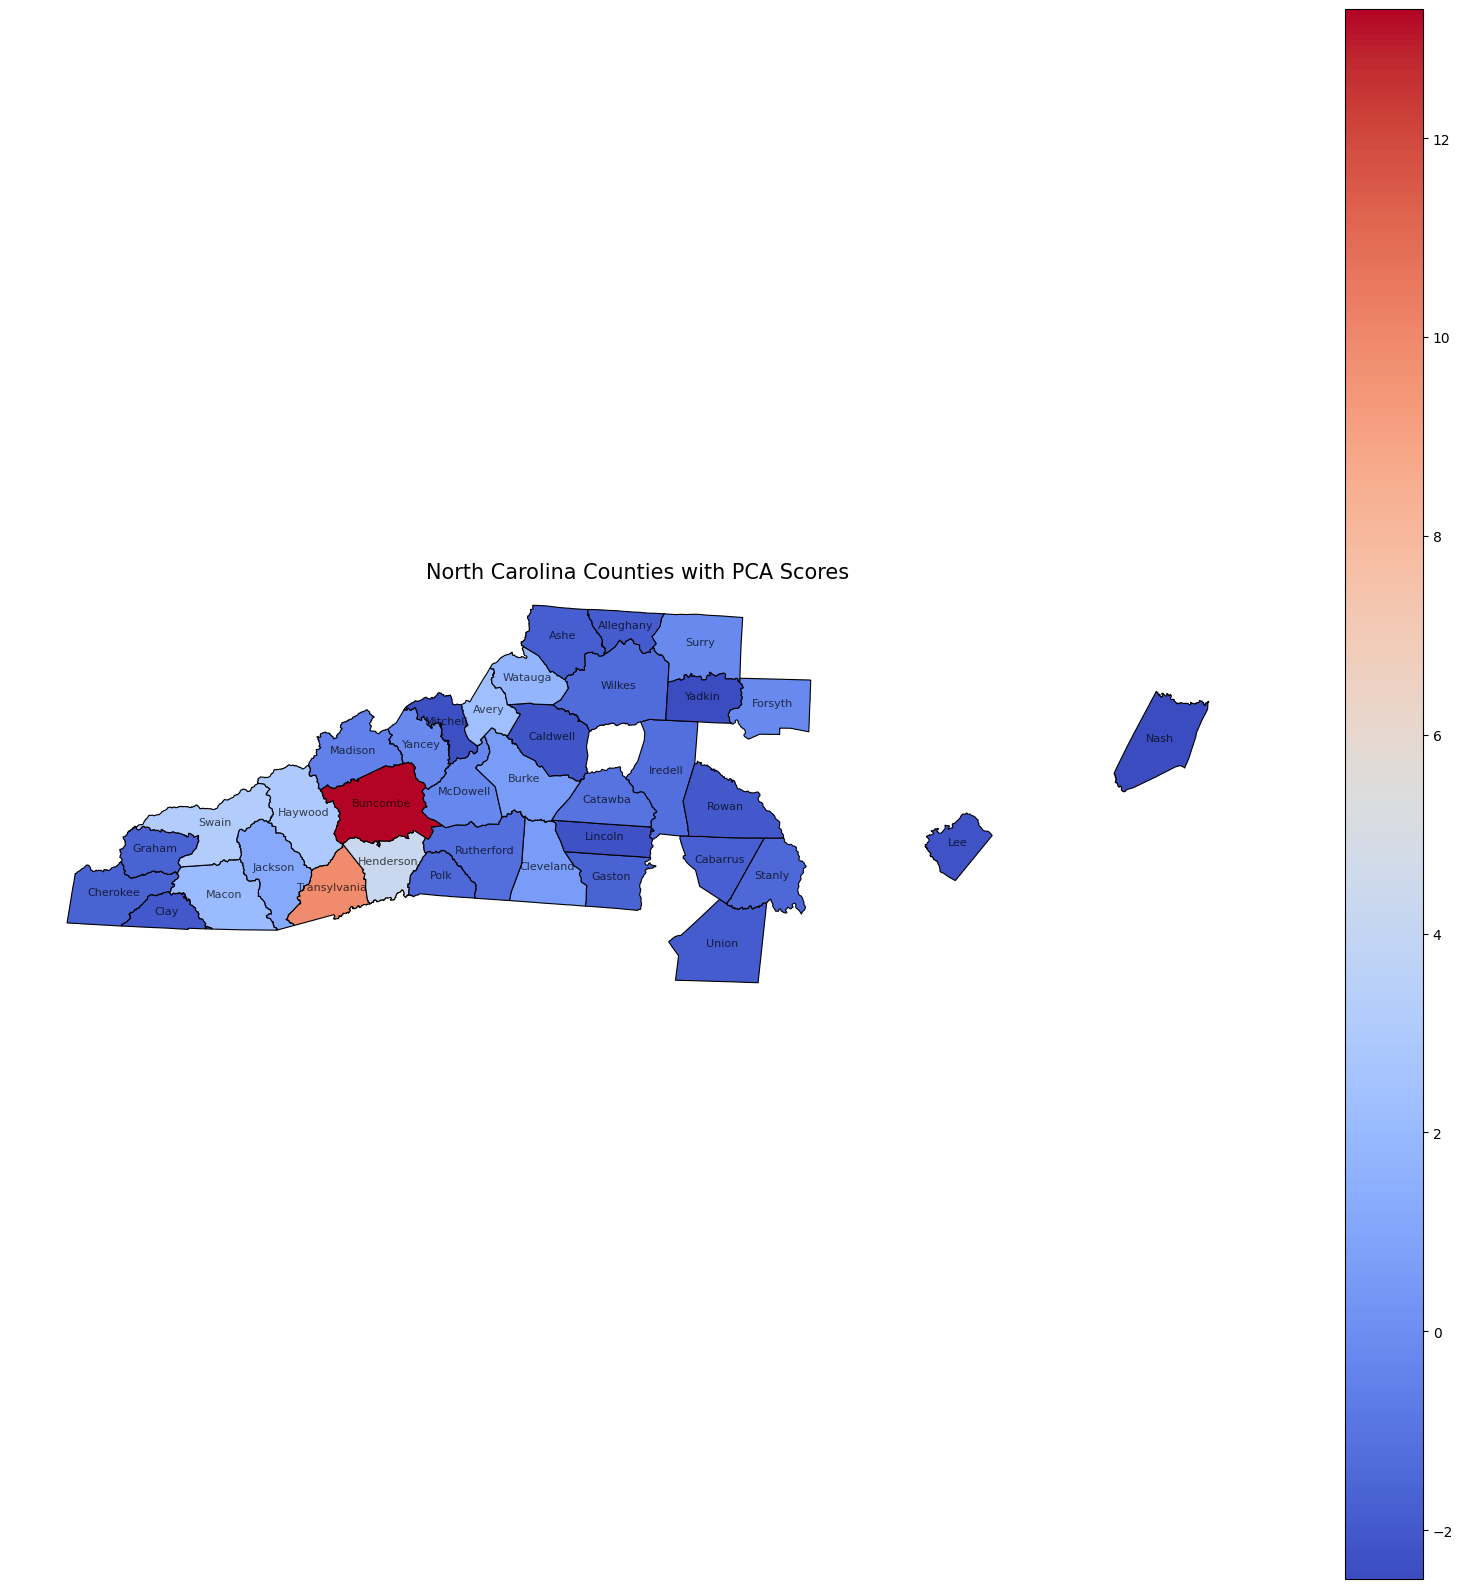

In [29]:

# Apply PCA for 1D embedding
pca_reducer = PCA(n_components=1)
embedding_1d = pca_reducer.fit_transform(normalized_values)

# Create a sorted table of counties by their 1D PCA embedding values
sorted_table = pd.DataFrame({
    'County': county_names,
    'PCA_1D': embedding_1d.flatten()
}).sort_values(by='PCA_1D')

print("Sorted Counties by 1D PCA Embedding:")
print(sorted_table)


# Load geographic data for NC counties
nc_counties = gpd.read_file("Boundaries/NCDOT_County_Boundaries.shp")  # Update with the correct path
nc_counties['NAME'] = nc_counties['NAME'].str.strip()  # Ensure no trailing spaces in county names

# Merge cluster labels and PCA scores with geographic data
normalized_data['PCA_1D'] = embedding_1d.flatten()
merged_data = nc_counties.merge(normalized_data, left_on='NAME', right_on='County')

# Plot counties colored by PCA score
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
merged_data.plot(
    column='PCA_1D',
    cmap='coolwarm',
    linewidth=0.8,
    ax=ax,
    edgecolor='black',
    legend=True
)

# Add county labels without scores
for x, y, label in zip(merged_data.geometry.centroid.x, merged_data.geometry.centroid.y, merged_data['NAME']):
    ax.text(x, y, label, fontsize=8, ha='center', alpha=0.7)

ax.set_title("North Carolina Counties with PCA Scores", fontdict={'fontsize': '15', 'fontweight': '3'})
ax.axis('off')
plt.tight_layout()
plt.show()



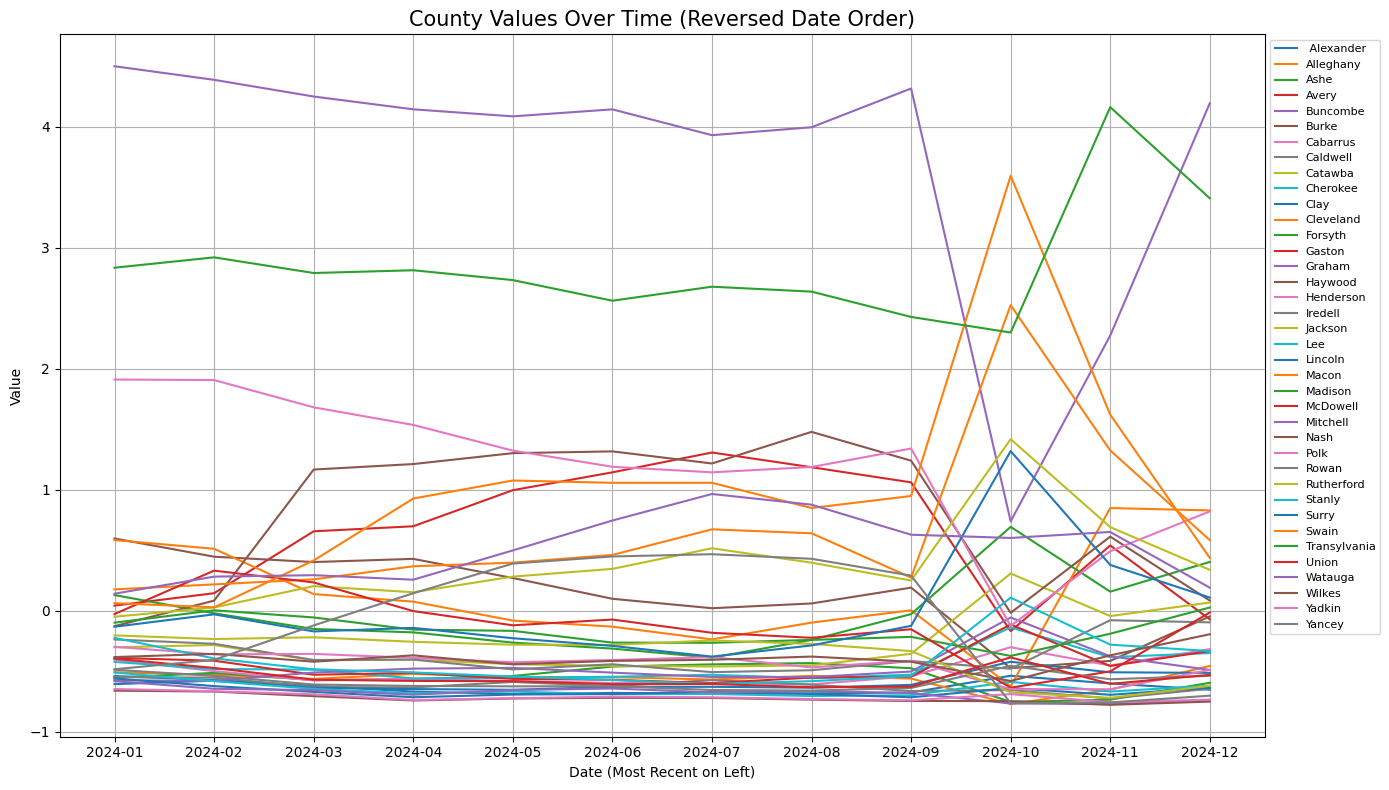

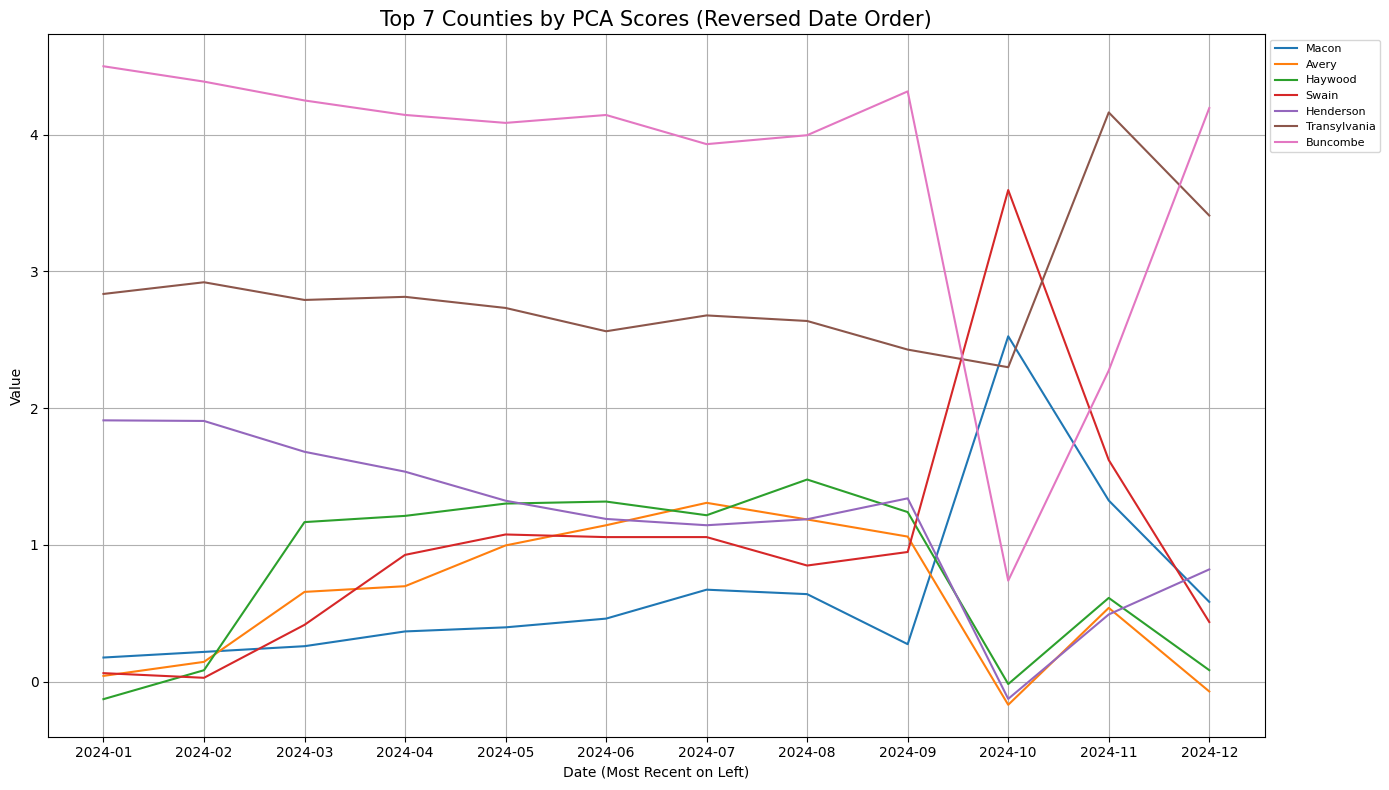

In [30]:
# Plot line chart of values over time for each county
date_columns = [col for col in normalized_data.columns if col.startswith("2022") or col.startswith("2023") or col.startswith("2024")]
plt.figure(figsize=(14, 8))
for county, row in normalized_data.iterrows():
    plt.plot(date_columns[::-1], row[date_columns].values[::-1], label=row['County'])

plt.title("County Values Over Time (Reversed Date Order)", fontsize=15)
plt.xlabel("Date (Most Recent on Left)")
plt.ylabel("Value")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot line chart for the 7 counties with the highest PCA scores
highest_pca = sorted_table.tail(7)
plt.figure(figsize=(14, 8))
for _, row in highest_pca.iterrows():
    county_data = normalized_data[normalized_data['County'] == row['County']]
    plt.plot(date_columns[::-1], county_data[date_columns].values.flatten()[::-1], label=row['County'])

plt.title("Top 7 Counties by PCA Scores (Reversed Date Order)", fontsize=15)
plt.xlabel("Date (Most Recent on Left)")
plt.ylabel("Value")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

